In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install torch torchvisyion torchaudio --index-url https://download.pytorch.org/whl/cu117

In [3]:
# !pip install torch
!pip install matplotlib
!pip install tensorflow
!pip install seaborn
!pip install pydot

In [4]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


In [5]:
!pip install matplotlib

In [6]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [7]:
!pip install pathlib

In [8]:
from pathlib import Path

# Defining the path for train and test images
train = Path("../Skin cancer/Train/")
test = Path("../Skin cancer/Test/")


In [9]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [10]:
import os
from collections import defaultdict

def count_images_per_class(directory):
    class_counts = defaultdict(int)
    for root, _, files in os.walk(directory):
        for file in files:
            class_name = os.path.basename(root)
            class_counts[class_name] += 1
    return class_counts

# Count the number of images per class in the train directory
train_class_counts = count_images_per_class(train)

# Count the number of images per class in the test directory
test_class_counts = count_images_per_class(test)

# Find the class with the lowest and highest number of samples in the train directory
train_min_class = min(train_class_counts, key=train_class_counts.get)
train_max_class = max(train_class_counts, key=train_class_counts.get)

# Find the class with the lowest and highest number of samples in the test directory
test_min_class = min(test_class_counts, key=test_class_counts.get)
test_max_class = max(test_class_counts, key=test_class_counts.get)

print("Train - Class with the lowest number of samples:")
print(train_min_class, train_class_counts[train_min_class])
print("Train - Class with the highest number of samples:")
print(train_max_class, train_class_counts[train_max_class])

print("Test - Class with the lowest number of samples:")
print(test_min_class, test_class_counts[test_min_class])
print("Test - Class with the highest number of samples:")
print(test_max_class, test_class_counts[test_max_class])


Train - Class with the lowest number of samples:
seborrheic keratosis 77
Train - Class with the highest number of samples:
output 40500
Test - Class with the lowest number of samples:
seborrheic keratosis 3
Test - Class with the highest number of samples:
actinic keratosis 16


##### Visualize one instance of all the class present in the dataset

Found 42739 files belonging to 9 classes.


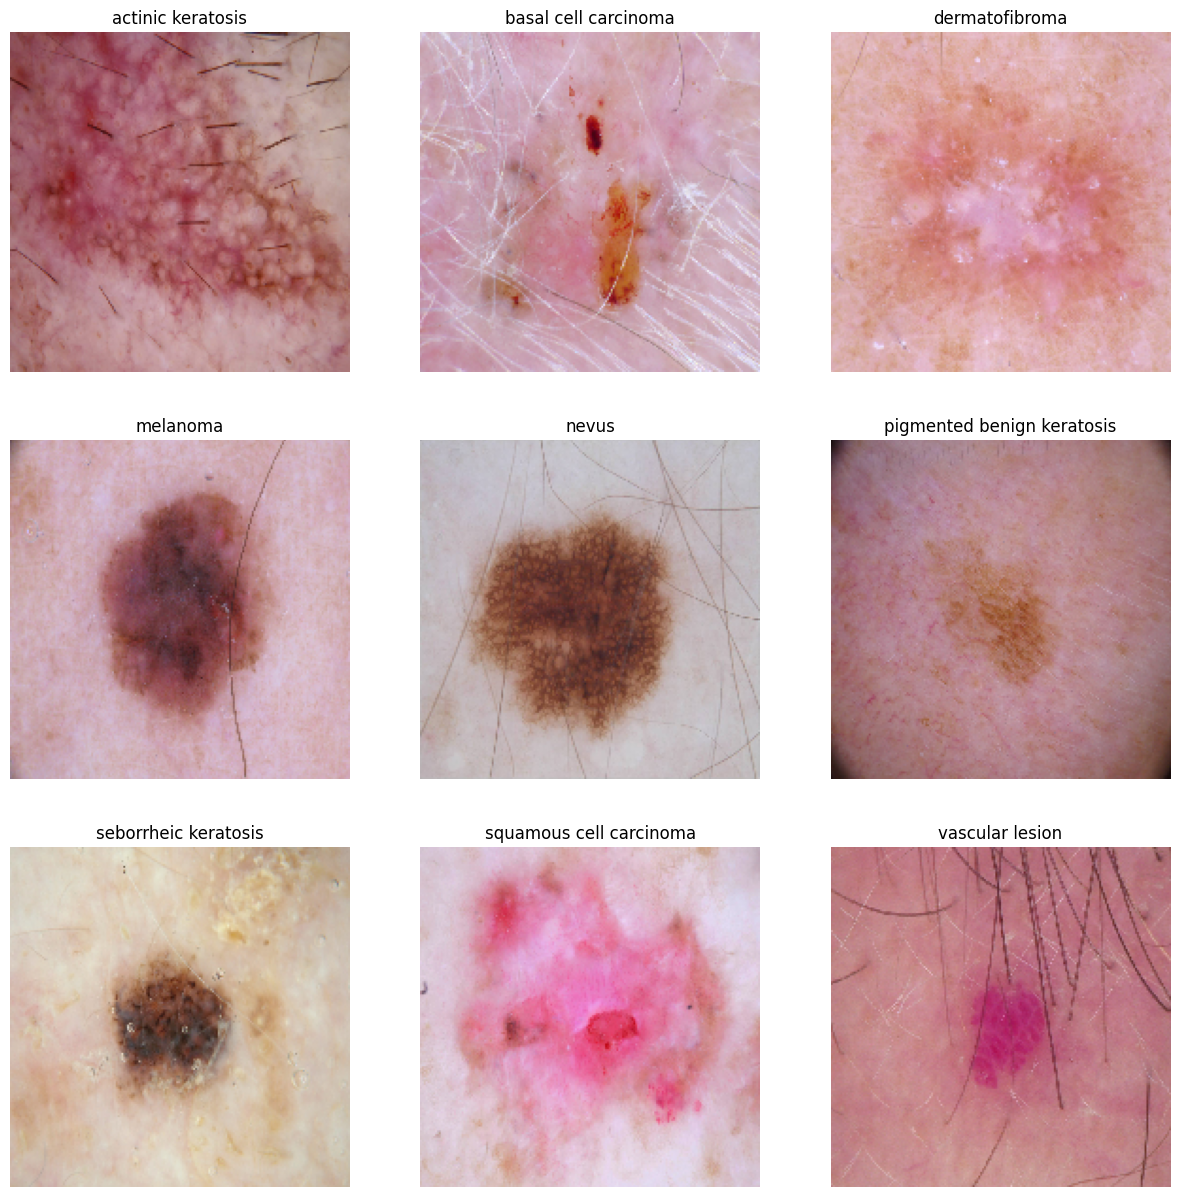

In [11]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(train)+'/'+c+'/'+x,os.listdir(str(train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

Visualize distribution of classes in the training dataset.

In [12]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


## Resizing the images

In [13]:
# import os
# from PIL import Image

# def resize_images(directory, target_size):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     resized_img = img.resize(target_size)
#                     resized_img.save(file_path)  # Overwrite the original image with the resized version
#             except (IOError, OSError):
#                 print(f"Error resizing image: {file_path}")

# # Specify the target size for resizing
# target_size = (180, 180)

# # Resize the images in the train directory
# resize_images(train, target_size)

# # Resize the images in the test directory
# resize_images(test, target_size)


##Normalizing the pixel values between (0,1)

In [14]:
# import os
# from PIL import Image
# import numpy as np

# def rescale_images(directory):
#     for root, _, files in os.walk(directory):
#         for file in files:
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img_array = np.array(img)
#                     img_array = img_array.astype(np.float32)  # Convert to float32
#                     rescaled_img_array = img_array / 255.0
#                     rescaled_img = Image.fromarray(rescaled_img_array.astype(np.uint8))  # Convert back to uint8
#                     rescaled_img.save(file_path)  # Overwrite the original image with the rescaled version
#             except (IOError, OSError):
#                 print(f"Error rescaling image: {file_path}")

# # Rescale the images in the train directory
# rescale_images(train)

# # Rescale the images in the test directory
# rescale_images(test)


Visualize distribution of classes in the training dataset

In [15]:
from pathlib import Path
import os
import pandas as pd

def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

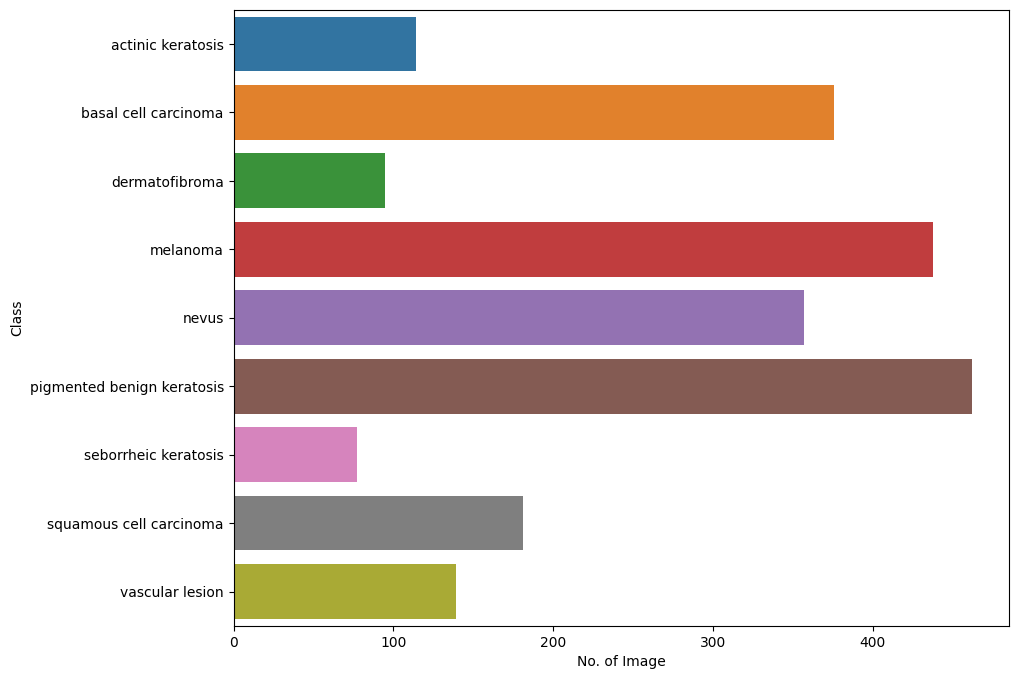

In [16]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [17]:
#install Augmentor
# !pip install Augmentor

In [18]:
# path_to_training_dataset="../Skin cancer/Train/"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

In [19]:
# #Count total number of image generated by Augmentor.
# image_count_train = len(list(train.glob('*/output/*.jpg')))
# print(image_count_train)

Model Building

In [20]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 42739 files belonging to 9 classes.
Using 34192 files for training.


In [21]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 42739 files belonging to 9 classes.
Using 8547 files for validation.


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [24]:
# !pip install pydot
# !winget install graphviz

In [25]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model2.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [27]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20


1069/1069 [==============================] - ETA: 0s - loss: 1.7568 - accuracy: 0.3167
Epoch 1: val_accuracy improved from -inf to 0.41219, saving model to model2.h5


c:\Users\susha\OneDrive\Desktop\Project\project\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1069/1069 [==============================] - 1035s 898ms/step - loss: 1.7568 - accuracy: 0.3167 - val_loss: 1.5733 - val_accuracy: 0.4122
Epoch 2/20
1069/1069 [==============================] - ETA: 0s - loss: 1.4416 - accuracy: 0.4489
Epoch 2: val_accuracy improved from 0.41219 to 0.48812, saving model to model2.h5
1069/1069 [==============================] - 974s 911ms/step - loss: 1.4416 - accuracy: 0.4489 - val_loss: 1.3422 - val_accuracy: 0.4881
Epoch 3/20
1069/1069 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.5182
Epoch 3: val_accuracy improved from 0.48812 to 0.54604, saving model to model2.h5
1069/1069 [==============================] - 953s 891ms/step - loss: 1.2663 - accuracy: 0.5182 - val_loss: 1.1916 - val_accuracy: 0.5460
Epoch 4/20
1069/1069 [==============================] - ETA: 0s - loss: 1.1447 - accuracy: 0.5624
Epoch 4: val_accuracy improved from 0.54604 to 0.60068, saving model to model2.h5
1069/1069 [==============================] - 939

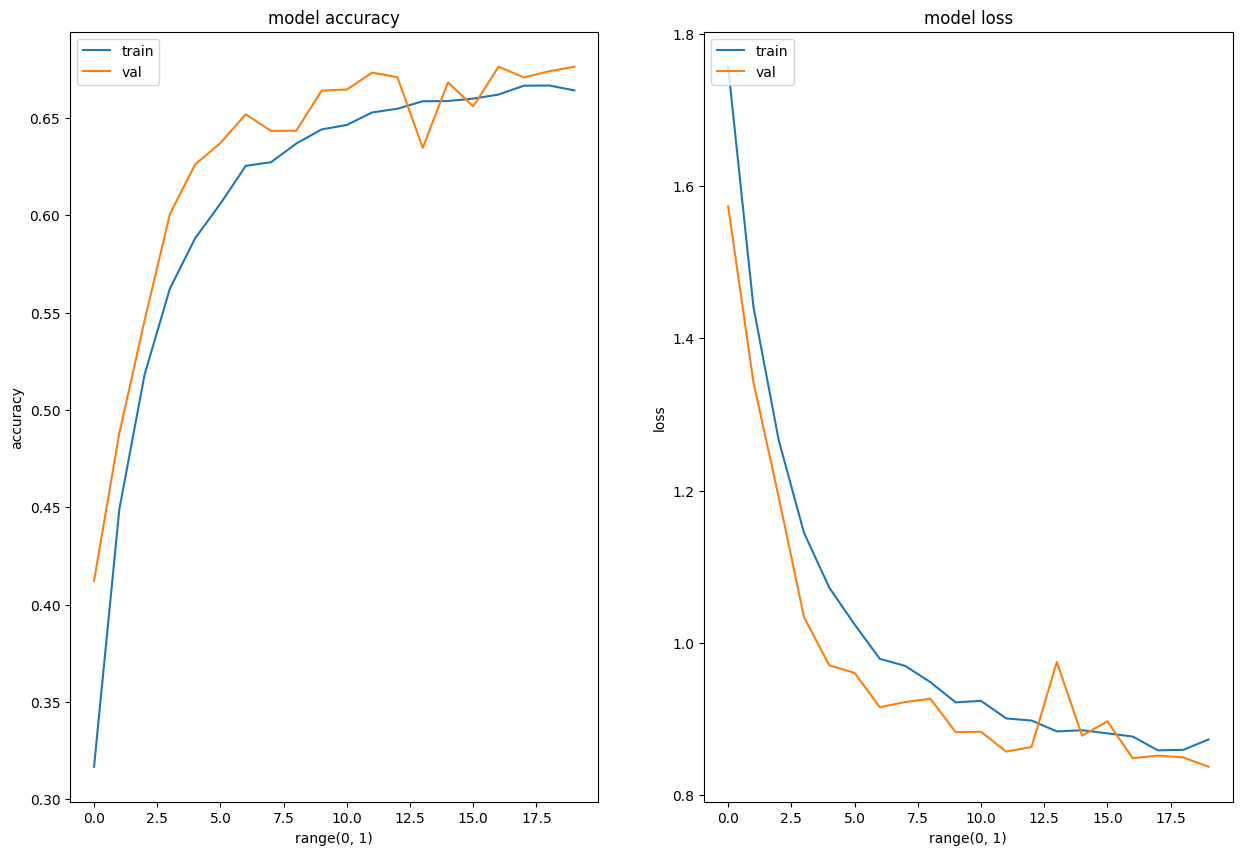

In [28]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Prediction

1/1 [==============================] - 0s 297ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


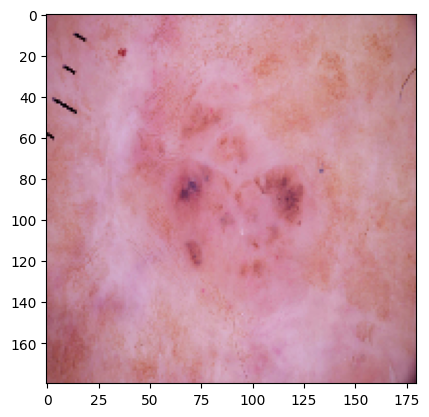

In [29]:
from glob import glob
Test_image_path = os.path.join(test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

Here since we have not used Augmentation hence that could be one of the reaon for getting less accuracy, however we can make experimental changes to the convolutional layers like include more layers to get more feature maps and get higher accuracy. Due to time constraint I have not been able to do much experiment in order to get high accuracy.

Additionally we can use a better weight initializer technique with a different optimizer which could improve the accuracy.

However since we don't have huge different between out training and validation accuracy hence we can conclude that we dont have underfitting or overfitting issues in our model.